In [1]:
# Setting up the Colab page to use neqsim
%%capture
!pip install neqsim
from neqsim.process import openprocess
import urllib
import time
# Importing the TEG process from file
!wget https://github.com/equinor/neqsimprocess/raw/master/lib/TEGprocess.neqsim

In [2]:
# importing the process from the stored file
# See: https://github.com/equinor/neqsimprocess/blob/master/src/neqsimprocess/glycol/TEGprocess.java
# See Figure 1 for process flow diagram
TEGprocess = openprocess('TEGprocess.neqsim')

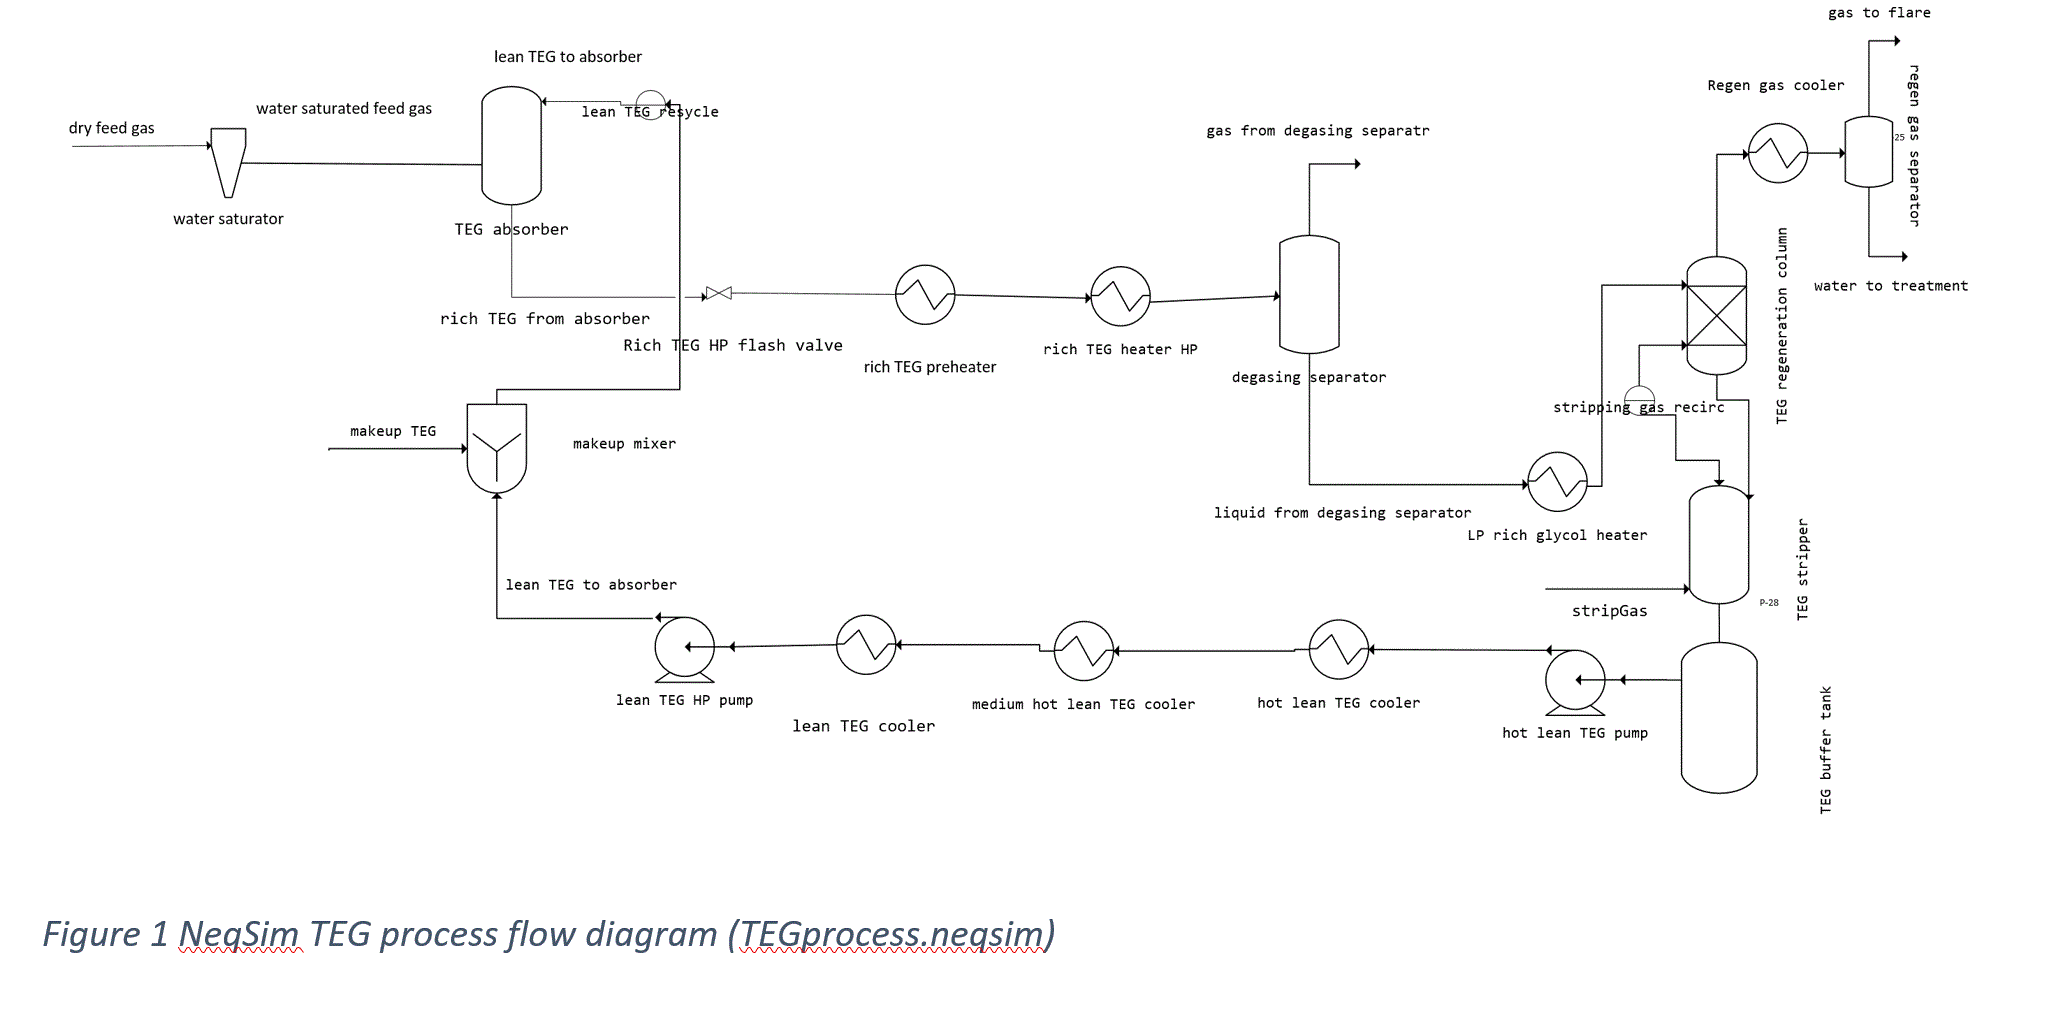

In [3]:
# Set input parameters
TEGprocess.getUnit("dry feed gas").setFlowRate(11.23, 'MSm3/day')
TEGprocess.getUnit("dry feed gas").setTemperature(30.4, 'C')
TEGprocess.getUnit("dry feed gas").setPressure(52.21, "bara")
TEGprocess.getUnit("lean TEG to absorber").setFlowRate(6862.5, "kg/hr")
TEGprocess.getUnit("Rich TEG HP flash valve").setOutletPressure(4.9)
TEGprocess.getUnit("rich TEG heater HP").setOutTemperature(273.15 + 62.0)
TEGprocess.getUnit("LP rich glycol heater").setOutTemperature(273.15 + 139.0)
TEGprocess.getUnit("LP rich glycol heater").setOutPressure(1.23)
TEGprocess.getUnit("TEG regeneration column").getCondenser().setOutTemperature(273.15 + 101.3)
TEGprocess.getUnit("TEG regeneration column").getReboiler().setOutTemperature(273.15 + 206.6)
TEGprocess.getUnit("TEG regeneration column").setBottomPressure(1.23)
TEGprocess.getUnit("TEG regeneration column").setTopPressure(1.2)
TEGprocess.getUnit("regen gas cooler").setOutTemperature(273.15+37.5)
TEGprocess.getUnit("stripGas").setPressure(1.23, "bara")
TEGprocess.getUnit("stripGas").setFlowRate(91.2, "Sm3/hr")
TEGprocess.getUnit("stripGas").setTemperature(80.0, 'C')
TEGprocess.getUnit("TEG buffer tank").setOutTemperature(273.15+185.0)
TEGprocess.getUnit("hot lean TEG pump").setOutletPressure(20.0)
TEGprocess.getUnit("hot lean TEG pump").setIsentropicEfficiency(0.75)
TEGprocess.getUnit("lean TEG cooler").setOutTemperature(273.15+43.0)                            
TEGprocess.getUnit("lean TEG HP pump").setOutletPressure(52.21)                          
TEGprocess.getUnit("lean TEG HP pump").setIsentropicEfficiency(0.75)

In [4]:
#Run the process calculations
tic = time.perf_counter()
TEGprocess.run()
toc = time.perf_counter()
print(f"Simulation run in {toc - tic:0.4f} seconds")

Simulation run in 54.8128 seconds


In [5]:
#Read results
wetGasRatekghr = TEGprocess.getUnit("water saturated feed gas").getFlowRate("kg/hr")
waterInWetGasppm = TEGprocess.getUnit("water saturated feed gas").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
waterInDryGasppm = TEGprocess.getUnit("dry gas from absorber").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
waterInWetGaskgMSm3 = waterInWetGasppm*0.01802*101325.0/(8.314*288.15)
waterInWetGaskghr = waterInWetGaskgMSm3*TEGprocess.getUnit("dry feed gas").getFlowRate("Sm3/day")/1.0e6/24.0
waterInDryGaskgMSm3 = waterInDryGasppm*0.01802*101325.0/(8.314*288.15)
wtLeanTEGFromReboiler = TEGprocess.getUnit("TEG regeneration column").getLiquidOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
wtLeanTEGFromStripper = TEGprocess.getUnit("TEG stripper").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
wtRichTEGFromAbsorber = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
richTEGtemperature = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getTemperature("C")
waterInRichTEGkghr = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water")*TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getFlowRate("kg/hr")
TEGcirculationratelitreperkg = TEGprocess.getUnit("TEG absorber").getSolventInStream().getFlowRate("kg/hr")*wtLeanTEGFromStripper/100/waterInWetGaskghr
richTEGtemperatureAfterDepres = TEGprocess.getUnit("Rich TEG HP flash valve").getOutStream().getFluid().getTemperature("C")
RichTEGwtprbinary = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")/(TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")+TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water"))*100
reboilerdutykW = TEGprocess.getUnit("TEG regeneration column").getReboiler().getDuty()/1.0e3
condenserdutykW = TEGprocess.getUnit("TEG regeneration column").getCondenser().getDuty()/1.0e3
glycolheater2dutykW = TEGprocess.getUnit("rich TEG heater HP").getDuty()/1.0e3
condensertemperature= TEGprocess.getUnit("TEG regeneration column").getCondenser().getTemperature()-273.15
reboilertemperature= TEGprocess.getUnit("TEG regeneration column").getReboiler().getTemperature()-273.15
TEGmakeupkghr = TEGprocess.getUnit("makeup calculator").getOutputVariable().getFluid().getFlowRate("kg/hr")
TEGmakeupkgMSm3 = TEGmakeupkghr/TEGprocess.getUnit("dry feed gas").getFlowRate("Sm3/day")/1.0e6*24
leanTEGflow = TEGprocess.getUnit("TEG absorber").getSolventInStream().getFlowRate("kg/hr")
richTEGflow = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFlowRate("kg/hr")
pump1DutykW = TEGprocess.getUnit("hot lean TEG pump").getEnergy()/1.0e3
pump2DutykW = TEGprocess.getUnit("lean TEG HP pump").getEnergy()/1.0e3
flashGasRate = TEGprocess.getUnit("gas from degasing separator").getFlowRate("kg/hr")
gasToFLareRatekghr = TEGprocess.getUnit("gas to flare").getFlowRate("kg/hr")
stripGasRatekghr = TEGprocess.getUnit("stripGas").getFlowRate("kg/hr")
waterToTreatment = TEGprocess.getUnit("water to treatment").getFlowRate("kg/hr")
TEGinwatertoTreatmentwtprecent = TEGprocess.getUnit("water to treatment").getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
flowFromReboiler = TEGprocess.getUnit("TEG regeneration column").getReboiler().getLiquidOutStream().getFlowRate("kg/hr")
richTEGpreheaterDutykW = TEGprocess.getUnit("rich TEG preheater").getDuty()/1000.0
richTEGpreheaterTemperature = TEGprocess.getUnit("rich TEG preheater").getOutStream().getTemperature("C")

In [6]:
# Print results
print('Wet gas rate ', wetGasRatekghr, ' kg/hr')
print('Water in wet gas ', waterInWetGasppm, ' ppm (mol)')
print('Water in dry gas ', waterInDryGasppm, ' ppm (mol)')
print('Water in wet gas ', waterInWetGasppm, ' kg/MSm3')
print('Water in dry gas ', waterInDryGasppm, ' kg/MSm3')
print('wt% TEG from absorber' , wtRichTEGFromAbsorber, ' wt%')
print('wt% TEG from reboiler ', wtLeanTEGFromReboiler, ' wt%')
print('wt% TEG from stripper ', wtLeanTEGFromStripper, ' wt%')
print('Reboiler duty ', reboilerdutykW, ' kW')
print('Condenser duty ', condenserdutykW, ' kW')
print('rich TEG preheater duty ', richTEGpreheaterDutykW, ' kW')
print('rich TEG heater HP duty', glycolheater2dutykW, ' kW')
print('temperature from condenser ', condensertemperature, ' C')
print('temperature from reboiler ', reboilertemperature, ' C')
print('TEG makeup ', TEGmakeupkghr, ' kg/hr')
print('lean TEG flow ', leanTEGflow, ' kg/hr')
print('rich TEG flow ', richTEGflow, ' kg/hr')
print('hot lean TEG pump duty ', pump1DutykW, ' kW')
print('lean TEG HP pump duty ', pump2DutykW, ' kW')
print('gas from degasing separator ', flashGasRate, ' kg/hr')
print('gas to flare ', gasToFLareRatekghr, ' kg/hr')
print('temperature from TEG preheater ', richTEGpreheaterTemperature, ' C')

Wet gas rate  390009.09604752815  kg/hr
Water in wet gas  996.2467036001741  ppm (mol)
Water in dry gas  24.89327580715244  ppm (mol)
Water in wet gas  996.2467036001741  kg/MSm3
Water in dry gas  24.89327580715244  kg/MSm3
wt% TEG from absorber 93.67250910497825  wt%
wt% TEG from reboiler  99.0447289929633  wt%
wt% TEG from stripper  99.82068345357335  wt%
Reboiler duty  510.9550866144118  kW
Condenser duty  -23.88329791139958  kW
rich TEG preheater duty  23.883366212719586  kW
rich TEG heater HP duty 119.71661032766639  kW
temperature from condenser  101.30000000000001  C
temperature from reboiler  206.60000000000002  C
TEG makeup  0.3576539706676675  kg/hr
lean TEG flow  6862.499999999999  kg/hr
rich TEG flow  7312.677522508925  kg/hr
hot lean TEG pump duty  4.83823230408004  kW
lean TEG HP pump duty  7.755699210919556  kW
gas from degasing separator  51.32078633535692  kg/hr
gas to flare  119.53478452640461  kg/hr
temperature from TEG preheater  37.64085194115768  C


In [7]:
#saving process status to file
TEGprocess.save('TEGprocess2.neqsim')